http://geopandas.org/data_structures.html

In [73]:
%%html

<style>

.container {
    width: 1200px;
}

.text_cell {
    background-color: #ccddcc;
}

.rendered_html code {
    color: #778877;
    background-color: #ccddcc;
}

</style>

In [2]:
import geopandas as gpd

In [3]:
%matplotlib inline

In [18]:
naturalearth_lowres = gpd.datasets.get_path('naturalearth_lowres')

In [19]:
# import fiona; help(fiona.open)  # uncomment me for help
world = gpd.read_file(naturalearth_lowres)

In [20]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


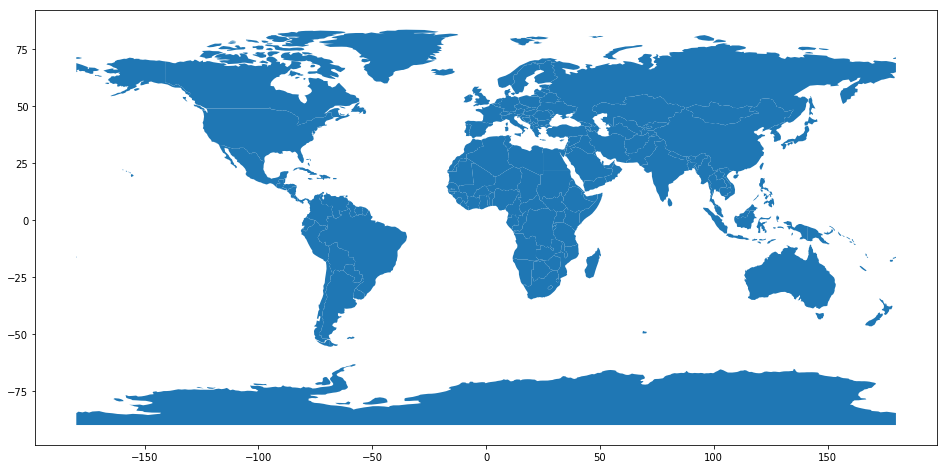

In [40]:
world.plot(figsize=(20, 8))

In [22]:
southern_world = world.cx[:, :0]

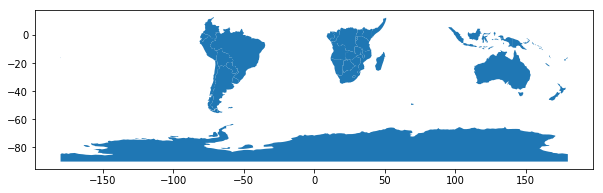

In [23]:
southern_world.plot(figsize=(10, 3))

-----

GeoPandas inherits the standard `pandas` methods for indexing/selecting data. This includes label based indexing with `.loc` and integer position based indexing with `.iloc`, which apply to both `GeoSeries` and `GeoDataFrame` objects. For more information on indexing/selecting, see the [pandas](http://pandas.pydata.org/pandas-docs/stable/indexing.html) documentation.

In addition to the standard `pandas` methods, GeoPandas also provides coordinate based indexing with the `cx` indexer, which slices using a bounding box. Geometries in the `GeoSeries` or `GeoDataFrame` that intersect the bounding box will be returned.

Using the `world` dataset, we can use this functionality to quickly select all countries whose boundaries extend into the southern hemisphere.

-----

In [35]:
countries_whose_boundaries_extend_into_the_west_hemisphere = world.cx[-160:0, -60:]

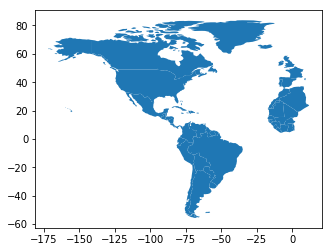

In [41]:
countries_whose_boundaries_extend_into_the_west_hemisphere.plot()

In [8]:
world.geometry.name

'geometry'

-----

Note: A GeoDataFrame keeps track of the active column by name, so if you rename the active geometry column, you must also reset the geometry:

`gdf = gdf.rename(columns={'old_name': 'new_name'}).set_geometry('new_name')`

-----

In [9]:
world = world.rename(columns={'geometry': 'borders'}).set_geometry('borders')

In [10]:
world.geometry.name

'borders'

-----

Note 2: Somewhat confusingly, by default when you use the `read_file` command, the column containing spatial objects from the file is named “geometry” by default, and will be set as the active geometry column. However, despite using the same term for the name of the column and the name of the special attribute that keeps track of the active column, they are distinct. You can easily shift the active geometry column to a different `GeoSeries` with the `set_geometry` command. Further, `gdf.geometry` will always return the active geometry column, *not* the column named `geometry`. If you wish to call a column named “geometry”, and a different column is the active geometry column, use `gdf['geometry']`, not `gdf.geometry`.

-----

In [11]:
world['centroid_column'] = world.centroid

In [12]:
world = world.set_geometry('centroid_column')

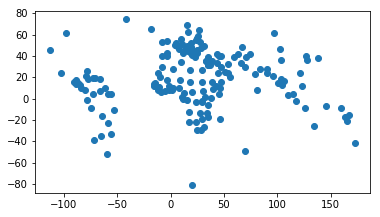

In [13]:
world.plot()

In [42]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

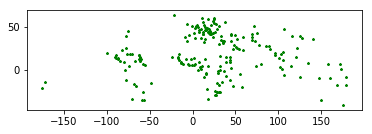

In [51]:
cities.plot(marker='*', color='green', markersize=5)

In [47]:
color_world = world[(world.pop_est > 0) & (world.name != "Antarctica")]

geopandas makes it easy to create Choropleth maps (maps where the color of each shape is based on the value of an associated variable). Simply use the plot command with the column argument set to the `column` whose values you want used to assign colors.

In [48]:
color_world['gdp_per_cap'] = color_world.gdp_md_est / color_world.pop_est

/Users/yy/anaconda3/envs/maps/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


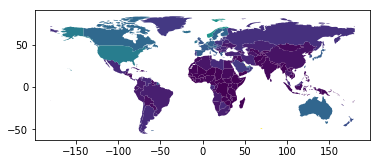

In [49]:
color_world.plot(column='gdp_per_cap')

-----

The way color maps are scaled can also be manipulated with the `scheme` option (if you have `pysal` installed, which can be accomplished via `conda install pysal`). The `scheme` option can be set to ‘equal_interval’, ‘quantiles’ or ‘percentiles’. See the [PySAL documentation](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html) for further details about these map classification schemes.

-----

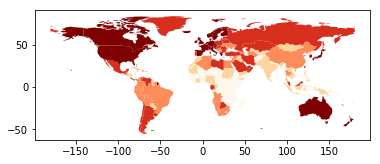

In [50]:
color_world.plot(column='gdp_per_cap', cmap='OrRd', scheme='quantiles')

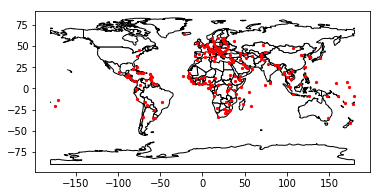

In [54]:
base = world.plot(color='white', edgecolor='black')

cities.plot(ax=base, marker='o', color='red', markersize=5)

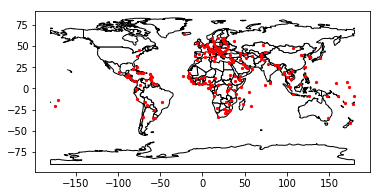

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

cities.plot(ax=ax, marker='o', color='red', markersize=5)

plt.show()

-----

**C**oordinate **R**eference **S**ystems are important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates related to places on the Earth.

CRS are referred to using codes called [proj4 strings](https://en.wikipedia.org/wiki/PROJ.4). You can find the codes for most commonly used projections from [spatialreference.org](http://spatialreference.org/) or [remotesensing.org](http://www.remotesensing.org/geotiff/proj_list/).

-----

... common projections can also be referred to by EPSG codes, so this same projection can also called using the proj4 string `"+init=epsg:4326"`.

-----

geopandas can accept lots of representations of CRS, including the proj4 string itself (`"+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"`) or parameters broken out in a dictionary: `{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}`).

-----

-----

Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the `from_file()` command) should always include projection information. You can see an objects current CRS through the `crs` attribute: `my_geoseries.crs`.

-----

-----

*Re-projecting* is the process of changing the representation of locations from one coordinate system to another. All projections of locations on the Earth into a two-dimensional plane [are distortions](https://en.wikipedia.org/wiki/Map_projection#Which_projection_is_best.3F), the projection that is best for your application may be different from the projection associated with the data you import. In these cases, data can be re-projected using the `to_crs` command:

-----

In [74]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [75]:
world.crs

{'init': 'epsg:4326'}

Text(0.5,1,'WGS84 (lat/lon)')

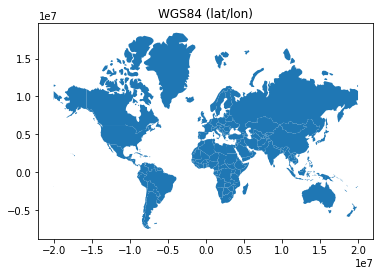

In [77]:
ax = world.plot()

ax.set_title("WGS84 (lat/lon)")

Text(0.5,1,'Mercator')

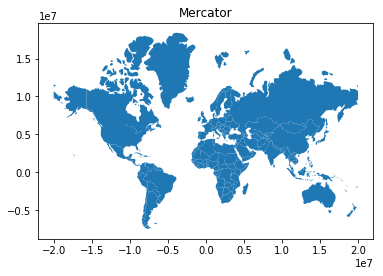

In [78]:
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

world = world.to_crs({'init': 'epsg:3395'})

ax = world.plot()

ax.set_title("Mercator")

geopandas makes available all the tools for geometric manipulations in the [*shapely* library](http://toblerity.org/shapely/manual.html).

Note that documentation for all set-theoretic tools for creating new shapes using the relationship between two different spatial datasets – like creating intersections, or differences – can be found on the [set operations](http://geopandas.org/set_operations.html) page.

In [80]:
from shapely.geometry import Polygon

In [89]:
p1 = Polygon([(0, 0), (1, 0), (1, 1)])

In [90]:
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])

In [91]:
from geopandas import GeoSeries

In [95]:
g = GeoSeries([p1, p2, p3])

In [96]:
g

0         POLYGON ((0 0, 1 0, 1 1, 0 0))
1    POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
2    POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
dtype: object

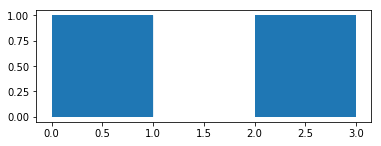

In [93]:
g.plot()

In [86]:
print(g.area)

0    0.5
1    1.0
2    1.0
dtype: float64


In [87]:
g.buffer(0.5)

0    POLYGON ((-0.3535533905932737 0.35355339059327...
1    POLYGON ((-0.5 0, -0.5 1, -0.4975923633360985 ...
2    POLYGON ((1.5 0, 1.5 1, 1.502407636663901 1.04...
dtype: object

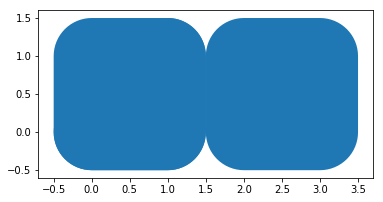

In [94]:
g.buffer(0.5).plot()

GeoPandas also implements alternate constructors that can read any data format recognized by `fiona`. To read a zip file containing an ESRI shapefile with the borough boundaries of New York City (GeoPandas includes this as an example dataset):

In [100]:
from geopandas import GeoDataFrame

In [102]:
nybb_path = gpd.datasets.get_path('nybb')
boros = GeoDataFrame.from_file(nybb_path)
boros.set_index('BoroCode', inplace=True)
#boros.sort()
boros

,BoroName,Shape_Leng,Shape_Area,geometry
BoroCode,,,,
5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


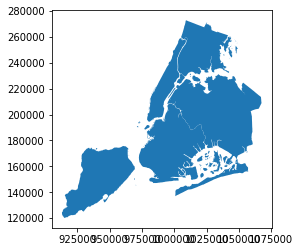

In [103]:
boros.plot()